In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import sys, h5py, torch, pickle, shutil

try:
    if shutil.which('pdflatex'):
        import scienceplots
        plt.style.use('science')
        plt.rcParams['pgf.texsystem'] = 'pdflatex'
    else:
        print('pdflatex is required to replicate the graphs exactly.')
except ModuleNotFoundError as e:
    print(f'{e}. To replicate the graphs exactly, run: pip install scienceplots')
    
plt.rcParams['ytick.right'] = False
plt.rcParams['font.size'] = 8.0
plt.rcParams['font.serif'] = 'Times'

device='cuda'
sys.path.append('../')
from equihash.utils.fingerprints import Fingerprints
fingerprints = Fingerprints(device=device)

In [2]:
results_paths = {
    'SH (64c3)': '../results/natural_mosaic_shannon_hamming_64c3_step_100000_valid.pkl',
    'SH (64c3+32c4)': '../results/natural_mosaic_shannon_hamming_64c3_32c4_step_100000_valid.pkl',
    r'HashNet ($\alpha$=$0.2$)': '../results/natural_mosaic_hashnet_0.2a_step_100000_valid.pkl',
    r'HashNet ($\alpha$=$0.15$)': '../results/natural_mosaic_hashnet_0.15a_step_100000_valid.pkl',
    r'HashNet ($\alpha$=$0.1$)': '../results/natural_mosaic_hashnet_0.1a_step_100000_valid.pkl',
}

fingerprints_path = {
    'SH (64c3)': '../fingerprints/natural_mosaic_shannon_hamming_64c3_step_100000_valid_fingerprints_2766.hdf5',
    'SH (64c3+32c4)': '../fingerprints/natural_mosaic_shannon_hamming_64c3_32c4_step_100000_valid_fingerprints_2766.hdf5',
    r'HashNet ($\alpha$=$0.2$)': '../fingerprints/natural_mosaic_hashnet_0.2a_step_100000_valid_fingerprints_2766.hdf5',
    r'HashNet ($\alpha$=$0.15$)': '../fingerprints/natural_mosaic_hashnet_0.15a_step_100000_valid_fingerprints_2766.hdf5',
    r'HashNet ($\alpha$=$0.1$)': '../fingerprints/natural_mosaic_hashnet_0.1a_step_100000_valid_fingerprints_2766.hdf5',
}

In [3]:
bs = 10_000_000

hamming_distances = dict()
for name, path in fingerprints_path.items():
    path = fingerprints_path[name]
    with h5py.File(path, 'r') as f:
        codes = torch.tensor(f['codes'][:2*bs], device=device)
    hamming_distances[name] = fingerprints.uint8_hamming_distance(codes[:bs], codes[bs:2*bs]).cpu().numpy()

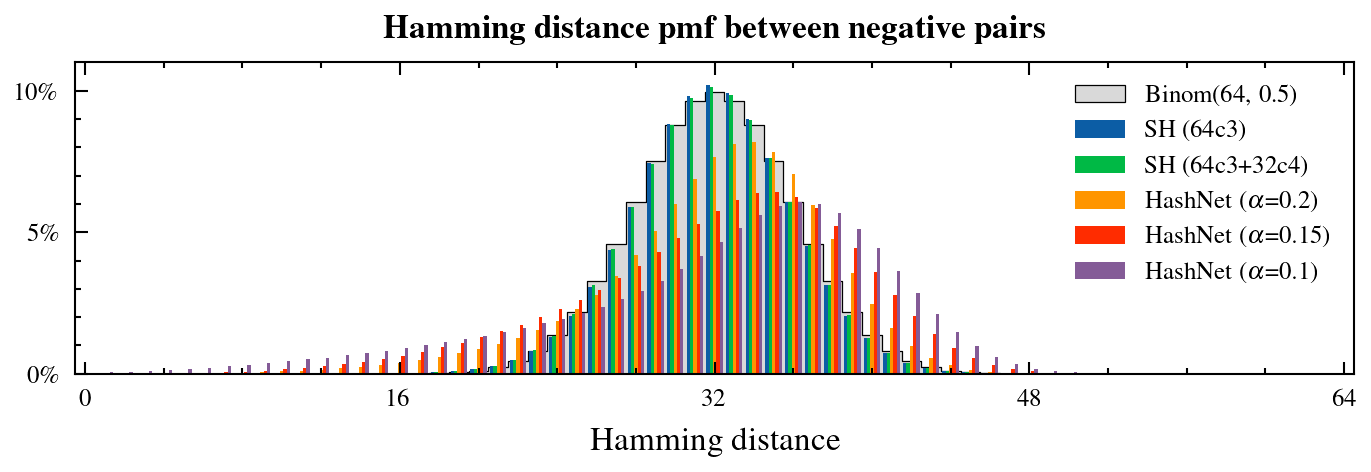

In [4]:
from scipy.stats import binom
binom_pmf = binom(n=64, p=0.5).pmf(np.arange(65))

n = len(hamming_distances)
width= 1 / (n+1)
fig = plt.figure(figsize=(5.5, 1.375), dpi=300)
fig.patch.set_facecolor('white')
ax = fig.add_subplot(111)

ax.fill_between(np.arange(65), binom_pmf, step='mid', facecolor=(0,0,0,0.15),
                edgecolor='black', linewidth=0.3, label='Binom(64, 0.5)')
for i, (label, hd) in enumerate(hamming_distances.items()):
    centers, counts = np.unique(hd, return_counts=True)
    probs = counts / counts.sum()
    edges = centers + width*(i-n/2)
    ax.bar(edges, probs, align='edge', width=width, label=label)

ax.set_title(r'\textbf{Hamming distance pmf between negative pairs}', size=8)

ax.set_ylim(0, 0.11)
ax.set_yticks([0, .05, .1])
ax.set_yticklabels(['0\\%', '5\\%', '10\\%'], size=6)

ax.set_xlim(-0.5, 64.5)
ax.set_xticks(np.arange(0, 65, 16), size=6);
ax.set_xticklabels(np.arange(0, 65, 16), size=6)
ax.set_xlabel('Hamming distance', size=8)

ax.legend(fontsize=6)
fig.savefig('negative_hamming_distance_pmf.png', bbox_inches='tight', transparent=False)

In [5]:
db_size = 1_000_000_000
pos_counts = dict()
neg_counts = dict()
for label, path in results_paths.items():
    with open(path, 'rb') as f:
        results = pickle.load(f)
    sizes = results['buckets_size'][db_size]
    pos_sizes = sizes[results['success']]
    neg_sizes = sizes[~results['success']]
    pc = [(pos_sizes==0).sum(), (pos_sizes==1).sum()]
    nc = [(neg_sizes==0).sum(), (neg_sizes==1).sum()]
    ranges = [2, 10, 100, 1000, 10000, np.inf]
    for a, b in zip(ranges[:-1], ranges[1:]):
        pc.append(np.logical_and(a <= pos_sizes, pos_sizes < b).sum())
        nc.append(np.logical_and(a <= neg_sizes, neg_sizes < b).sum())
    pos_counts[label] = np.array(pc)
    neg_counts[label] = np.array(nc)

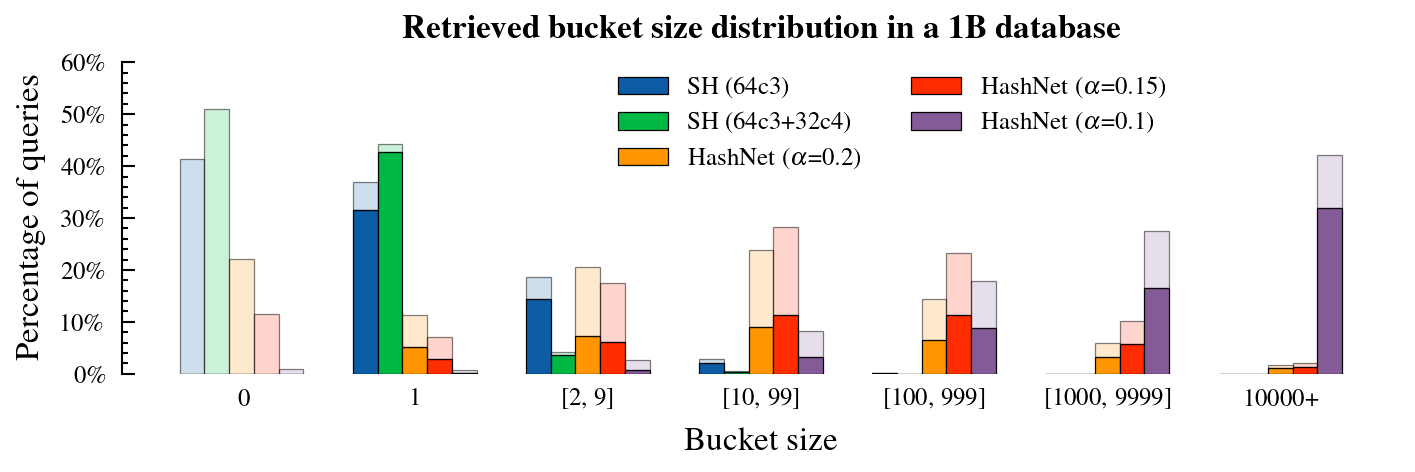

In [6]:
n = len(pos_counts)
width = 1 / (n+2)
fig = plt.figure(figsize=(5.5, 1.375), dpi=300)
fig.patch.set_facecolor('white')
ax = fig.add_subplot(111)

for i, label in enumerate(pos_counts.keys()):
    total = pos_counts[label].sum() + neg_counts[label].sum()
    pc = pos_counts[label]/total
    nc = neg_counts[label]/total
    edges = np.arange(7) + width*(i-n/2)
    b = ax.bar(edges, pc, align='edge', width=width,
           label=label, edgecolor='black', linewidth=0.3)
    color = b[0].get_facecolor()
    ax.bar(edges, nc, bottom=pc, color=color[:3]+(0.2,),
           align='edge', width=width, edgecolor=(0,0,0,0.5), linewidth=0.3)
    
ax.set_title(r'\textbf{Retrieved bucket size distribution in a 1B database}', size=8)
ax.tick_params(axis='x', which='both', length=0)
ax.spines[['right', 'top', 'bottom']].set_visible(False)

ax.set_xticks(np.arange(7)+0.015) #+0.015 because labels' text are not centered with ticks...
ax.set_xticklabels([0, 1, '[2, 9]', '[10, 99]', '[100, 999]', '[1000, 9999]', '10000+'], size=6)
ax.set_xlabel('Bucket size')

ax.set_ylim(0, 0.6)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax.set_yticklabels(['0\\%', '10\\%', '20\\%', '30\\%', '40\\%', '50\\%', '60\\%'], size=6)
ax.set_ylabel('Percentage of queries')

ax.legend(loc=(.38, .62), ncol=2, fontsize=6)
fig.savefig('retrieved_bucket_size_distribution_1b.png', bbox_inches='tight', transparent=False)

In [7]:
db_sizes = [1_000_000, 10_000_000, 100_000_000, 1_000_000_000]
prrs = dict()
for label, path in results_paths.items():
    with open(path, 'rb') as f:
        results = pickle.load(f)
    prrs[label] = np.array([results['perfect_retrieval'][db_size].mean() for db_size in db_sizes])

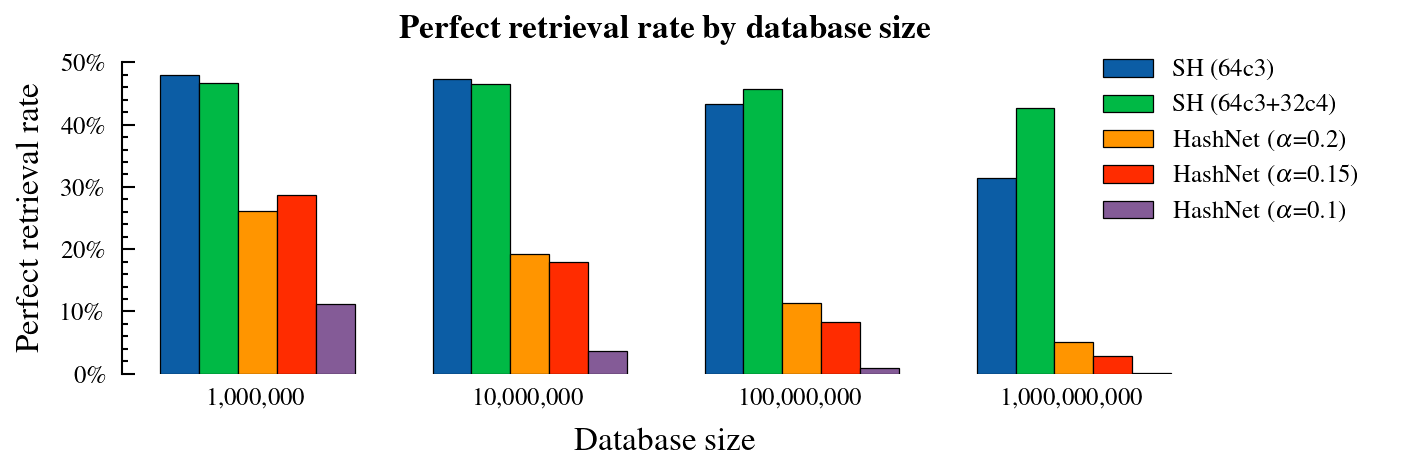

In [8]:
n = len(prrs)
width = 1 / (n+2)
fig = plt.figure(figsize=(5.5, 1.375), dpi=300)
fig.patch.set_facecolor('white')
ax = fig.add_subplot(111)

for i, (label, prr) in enumerate(prrs.items()):
    edges = np.arange(4) + width*(i-n/2)
    ax.bar(edges, prr, align='edge', width=width, label=label, edgecolor='black', linewidth=0.3)
    
title = ax.set_title(r'\textbf{Perfect retrieval rate by database size}', size=8)
title.set_position((0.425, 1)) #x = 0.5 * (3.5+0.5) / (4.2+0.5)
ax.tick_params(axis='x', which='both',length=0)
ax.spines[['right', 'top', 'bottom']].set_visible(False)

ax.set_ylim(0, 0.5)
ax.set_yticks([0, .1, .2, .3, .4, .5])
ax.set_yticklabels(['0\\%', '10\\%', '20\\%', '30\\%', '40\\%', '50\\%'], size=6)
ax.set_ylabel('Perfect retrieval rate', size=8)

ax.set_xlim(-0.5, 4.2) #default -0.5 to 3.5. we set it to 4.2 to fit legend in and not change the width of the graph
ax.set_xticks(range(4))
ax.set_xticklabels([f'{s:,}' for s in db_sizes], size=6)
xlabel = ax.set_xlabel('Database size', size=8)
xlabel.set_position((0.425, 1))

ax.legend(loc=(0.76,0.45), fontsize=6)
fig.savefig('perfect_retrieval_rate.png', bbox_inches='tight')